In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from pymongo import MongoClient
from spacy.en import English

In [3]:
client = MongoClient('localhost', 27017)
db = client.python_import
collection = db.earnings_transcript

In [4]:
transcripts = pd.DataFrame(list(collection.find().limit(50)))

In [5]:
transcripts.head(1)

,_id,date_number,h_tone,publishDate,qAndAText,q_and_a_h_tone,q_and_a_wordSize,rawText,time_number,tradingSymbol,url,wordSize
0,5937dba3082789410c746a1e,1130423,"{'positiveCount': 203, 'negativeCount': 75}",2013-04-23 21:30:07,Operator [Operator Instructions] We'll go firs...,"{'positiveCount': 117, 'negativeCount': 46}",7493,US Airways Group ( LCC ) Q1 2013 Earnings Call...,213007,AAL,https://seekingalpha.com/article/1363811-us-ai...,11310


In [6]:
nlp = English()

In [7]:
text = transcripts.iloc[0]['rawText']

In [8]:
doc = nlp(text)

In [9]:
len(doc)

11391

In [10]:
for i in range(0, 200):
    print('{} - {} - {} - {} - {}'.format(doc[i], doc[i].lemma_, doc[i].sentiment, doc[i].cluster, doc[i].pos_))

US - us - 0.0 - 1642 - PROPN
Airways - airways - 0.0 - 454 - PROPN
Group - group - 0.0 - 70 - PROPN
( - ( - 0.0 - 0 - PUNCT
LCC - lcc - 0.0 - 0 - PROPN
) - ) - 0.0 - 0 - PUNCT
Q1 - q1 - 0.0 - 0 - NUM
2013 - 2013 - 0.0 - 49 - NUM
Earnings - earning - 0.0 - 2046 - NOUN
Call - call - 0.0 - 1214 - VERB
April - april - 0.0 - 81 - PROPN
23 - 23 - 0.0 - 690 - NUM
, - , - 0.0 - 4 - PUNCT
2013 - 2013 - 0.0 - 49 - NUM
12:30 - 12:30 - 0.0 - 818 - NUM
PM - pm - 0.0 - 166 - NOUN
ET - et - 0.0 - 2045 - PROPN
Executives - executives - 0.0 - 1022 - PROPN
Daniel - daniel - 0.0 - 502 - PROPN
Cravens - cravens - 0.0 - 86 - PROPN
William - william - 0.0 - 502 - PROPN
Douglas - douglas - 0.0 - 1014 - PROPN
Parker - parker - 0.0 - 86 - PROPN
- - - - 0.0 - 36 - PUNCT
Executive - executive - 0.0 - 1702 - PROPN
Chairman - chairman - 0.0 - 758 - PROPN
, - , - 0.0 - 4 - PUNCT
Chief - chief - 0.0 - 758 - PROPN
Executive - executive - 0.0 - 1702 - PROPN
Officer - officer - 0.0 - 758 - PROPN
, - , - 0.0 - 4 - PUNCT

# Keyphrase extraction

In [11]:
import textacy

In [12]:
ranked = textacy.keyterms.sgrank(
    doc,
    normalize='lemma',
    ngrams = (2,3,4,5),
    n_keyterms=200,
)

In [13]:
ranked[:20]

[('buckingham research group incorporated', 0.22422951075122935),
 ('j. scott kirby', 0.1814021539446511),
 ('william douglas parker', 0.11181998851989701),
 ('derek j. kerr', 0.0593143512940076),
 ('bofa merrill lynch', 0.04463834448420273),
 ('glenn d. engel', 0.04344146038058111),
 ('robert d. isom', 0.0384018482614768),
 ('hunter k. keay', 0.035662464611214174),
 ('jp morgan chase', 0.03470658052222822),
 ('jamie n. baker', 0.03365279253216624),
 ('john d. godyn', 0.03338266619859783),
 ('research division', 0.022704861610778507),
 ('fuel price', 0.01536364306097041),
 ('low fuel price', 0.010454160468751215),
 ('special item', 0.007637661492688125),
 ('fourth quarter', 0.007574028775364999),
 ('savanthi syth', 0.007232144359557934),
 ('revenue environment', 0.007222965221552363),
 ('operator instructions', 0.006692683680558231),
 ('raymond james', 0.006689476579442346)]

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


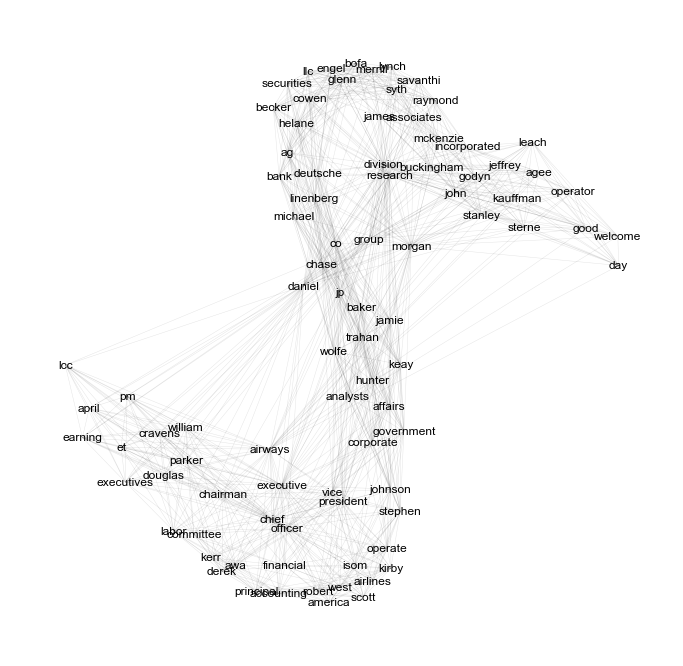

In [14]:
%pylab inline
textacy.viz.draw_semantic_network(
    textacy.keyterms.terms_to_semantic_network(
        [tok for tok in doc[:200] if not tok.is_stop and tok.pos_ in ["NOUN", "PROPN", "ADJ", "VERB"] and tok.is_alpha],
        normalize='lemma',
        edge_weighting='cooc_freq',
        window_width=15
    )
)

In [15]:
from textacy.text_utils import keyword_in_context

keyword_in_context(doc.text, "morgan", window_width=50)

 K. Keay - Wolfe Trahan & Co. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Michael Linenberg -
ngham Research Group Incorporated John D. Godyn -  Morgan  Stanley, Research Division Jeffrey A. Kauffman - 
we'll go next to Jamie Baker. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Scott, even before 
ot always a straight line up. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Okay, that's helpfu
eeing strengths in that line. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division And any additional 
hat we can't [indiscernible]. Jamie N. Baker - JP  Morgan  Chase & Co, Research Division Okay. Yes, yes. Der
ator We'll go next to John Godyn. John D. Godyn -  Morgan  Stanley, Research Division Scott, I wanted to ask
 lot easier to keep pricing firm. John D. Godyn -  Morgan  Stanley, Research Division Well, if we imagined a
he economy and good for airlines. John D. Godyn -  Morgan  Stanley, Research Division That's really helpful.


In [16]:
import math
from collections import Counter 
words = [tok for tok in doc if tok.is_alpha and not tok.is_stop and tok.pos_ in ["NOUN", "VERB", "ADJ", "PROPN"]]
word_probs = {tok.text.lower(): tok.prob for tok in words}

freqs = Counter(tok.text for tok in words)
word_scores = {tok: freqs[tok] for tok, prob in word_probs.items()}

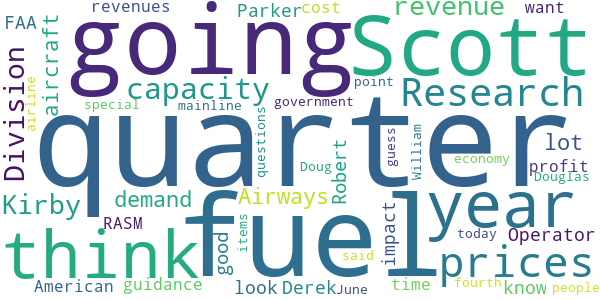

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white", max_words=50, scale=1.5).generate_from_frequencies(freqs)
image = wordcloud.to_image()
image.save("./wordcloud.png")
from IPython.display import Image 
Image(filename='./wordcloud.png')

In [18]:
def tokenize(doc):
    return [tok.lemma_ for tok in doc if tok.is_alpha and not tok.is_stop]

tokenize(doc)[300:320]

['date',
 'undertake',
 'obligation',
 'update',
 'information',
 'subsequently',
 'thank',
 'join',
 'point',
 'like',
 'turn',
 'chairman',
 'ceo',
 'doug',
 'parker',
 'william',
 'douglas',
 'parker',
 'thank',
 'dan']

# Load AFINN-111

In [19]:
afinn = pd.read_csv(filepath_or_buffer='AFINN-111.txt', sep='\t', header=None)

In [20]:
afinn.rename(index=str, columns={0: "Word", 1: "Score"}, inplace=True)

In [21]:
afinn.head(5)

,Word,Score
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [22]:
afinn[afinn['Word'] == 'shit']['Score'].get(0, 0)

-4

In [23]:
transcripts['NLP'] = transcripts['rawText'].apply(lambda val: nlp(val))

In [24]:
transcripts['tokens'] = transcripts['NLP'].apply(lambda val: tokenize(val))

In [25]:
def build_score_for_tokens(tokens):
    score_pos, score_neg = 0, 0
    for token in tokens:
        temp_score = afinn[afinn['Word'] == token]['Score'].get(0, 0)
        if temp_score > 0:
            score_pos += temp_score
        elif temp_score < 0:
            score_neg += temp_score
    return (score_pos, score_neg, score_pos + score_neg)

In [26]:
transcripts['Sentiment Score'] = transcripts['tokens'].apply(lambda val: build_score_for_tokens(val))

In [27]:
transcripts['SS Ratio'] = transcripts['Sentiment Score'].apply(lambda row: row[0]/(-row[1]))

In [28]:
transcripts['HTone Ratio'] = transcripts['h_tone'].apply(lambda row: row['positiveCount']/row['negativeCount'])

In [29]:
transcripts[['url', 'Sentiment Score', 'h_tone', 'SS Ratio', 'HTone Ratio']]

,url,Sentiment Score,h_tone,SS Ratio,HTone Ratio
0,https://seekingalpha.com/article/1363811-us-ai...,"(542, -171, 371)","{'positiveCount': 203, 'negativeCount': 75}",3.169591,2.706667
1,https://seekingalpha.com/article/1129431-apple...,"(679, -94, 585)","{'positiveCount': 236, 'negativeCount': 30}",7.223404,7.866667
2,https://seekingalpha.com/article/1287941-adobe...,"(657, -39, 618)","{'positiveCount': 170, 'negativeCount': 16}",16.846154,10.625000
3,https://seekingalpha.com/article/2711985-analo...,"(662, -109, 553)","{'positiveCount': 248, 'negativeCount': 62}",6.073394,4.000000
4,https://seekingalpha.com/article/2885106-autom...,"(1239, -136, 1103)","{'positiveCount': 411, 'negativeCount': 59}",9.110294,6.966102
5,https://seekingalpha.com/article/2425545-autod...,"(661, -63, 598)","{'positiveCount': 196, 'negativeCount': 23}",10.492063,8.521739
6,https://seekingalpha.com/article/2700495-autod...,"(581, -59, 522)","{'positiveCount': 202, 'negativeCount': 29}",9.847458,6.965517
7,https://seekingalpha.com/article/2957556-autod...,"(756, -63, 693)","{'positiveCount': 238, 'negativeCount': 30}",12.000000,7.933333
8,https://seekingalpha.com/article/3197526-autod...,"(711, -82, 629)","{'positiveCount': 191, 'negativeCount': 38}",8.670732,5.026316
9,https://seekingalpha.com/article/3473396-autod...,"(746, -98, 648)","{'positiveCount': 198, 'negativeCount': 31}",7.612245,6.387097


### Smaller sentiment score ratio

In [30]:
transcripts[transcripts['SS Ratio'] < transcripts['HTone Ratio']]['url']

1     https://seekingalpha.com/article/1129431-apple...
33    https://seekingalpha.com/article/1856531-autod...
36    https://seekingalpha.com/article/3993064-autom...
Name: url, dtype: object

### Much bigger sentiment score ratio

In [31]:
transcripts[(transcripts['SS Ratio'] / transcripts['HTone Ratio']) > 2.6]['url']

10    https://seekingalpha.com/article/3700786-autod...
12    https://seekingalpha.com/article/3976697-autod...
16    https://seekingalpha.com/article/4027140-autod...
18    https://seekingalpha.com/article/4074589-autod...
Name: url, dtype: object

In [32]:
transcripts['SS Ratio'].describe()

count    50.000000
mean      9.722506
std       3.218211
min       3.169591
25%       7.423282
50%       8.934743
75%      11.573004
max      16.846154
Name: SS Ratio, dtype: float64

# Textacy discovery

In [33]:
my_text = "Hey my darling's friends! I feel pretty zazzy today, what about you? Please send me some very basic interpretation of stuff. Orban Viktor is a really great prime minister, just like Donald Trump. Orban has the highest ranked stuff today, and it's pretty obvious for me, that Trump's interpretation was not so clear for everybody. Yesterday, Orban went to a monastery to regret his sins."

In [34]:
my_doc=textacy.Doc(my_text)

In [35]:
textacy.preprocess_text(my_text, lowercase=True, no_punct=True)

'hey my darlings friends i feel pretty zazzy today what about you please send me some very basic interpretation of stuff orban viktor is a really great prime minister just like donald trump orban has the highest ranked stuff today and its pretty obvious for me that trumps interpretation was not so clear for everybody yesterday orban went to a monastery to regret his sins'

In [36]:
list(textacy.extract.ngrams(my_doc, 3, filter_stops=True, filter_punct=True, filter_nums=False, min_freq=1))

[Hey my darling,
 darling's friends,
 feel pretty zazzy,
 pretty zazzy today,
 interpretation of stuff,
 great prime minister,
 like Donald Trump,
 highest ranked stuff,
 ranked stuff today,
 's pretty obvious,
 Trump's interpretation,
 clear for everybody,
 monastery to regret,
 regret his sins]

In [37]:
list(textacy.extract.named_entities(my_doc, drop_determiners=True, exclude_types='numeric'))

[Orban Viktor, Donald Trump, Orban, Trump, Orban]

In [38]:
pattern = textacy.constants.POS_REGEX_PATTERNS['en']['NP']

In [39]:
list(textacy.extract.pos_regex_matches(my_doc, pattern))

[my darling,
 friends,
 today,
 what,
 basic interpretation,
 stuff,
 Orban Viktor,
 great prime minister,
 Donald Trump,
 Orban,
 stuff today,
 Trump's interpretation,
 everybody,
 Yesterday,
 Orban,
 a monastery,
 his sins]

In [40]:
textacy.keyterms.textrank(my_doc, n_keyterms=10)

[('orban', 0.10821693462097956),
 ('today', 0.07514893757924468),
 ('trump', 0.07225138491842635),
 ('interpretation', 0.07136692518580731),
 ('stuff', 0.0699902649564003),
 ('friend', 0.04672327212340812),
 ('monastery', 0.04572391708596146),
 ('prime', 0.045341871824572035),
 ('minister', 0.044524908992018115),
 ('great', 0.0445130447660802)]

In [41]:
ts = textacy.text_stats.TextStats(my_doc)

In [42]:
ts.n_unique_words

55

In [43]:
ts.basic_counts

{'n_chars': 311,
 'n_long_words': 10,
 'n_monosyllable_words': 48,
 'n_polysyllable_words': 7,
 'n_sents': 5,
 'n_syllables': 99,
 'n_unique_words': 55,
 'n_words': 68}

In [44]:
ts.readability_stats

{'automated_readability_index': 6.911323529411764,
 'coleman_liau_index': 8.915332191176471,
 'flesch_kincaid_grade_level': 6.893411764705885,
 'flesch_readability_ease': 69.86335294117649,
 'gulpease_index': 65.32352941176471,
 'gunning_fog_index': 9.55764705882353,
 'lix': 28.305882352941175,
 'smog_index': 9.888512548439397,
 'wiener_sachtextformel': 2.989949411764706}

In [45]:
bot = my_doc.to_bag_of_terms(ngrams={2, 3}, as_strings=True)
sorted(bot.items(), key=lambda x: x[1], reverse=True)

[('today', 2),
 ('orban', 2),
 ('orban viktor', 1),
 ('donald trump', 1),
 ('trump', 1),
 ('yesterday', 1),
 ("darling 's", 1),
 ("'s friend", 1),
 ('feel pretty', 1),
 ('pretty zazzy', 1),
 ('zazzy today', 1),
 ('basic interpretation', 1),
 ('great prime', 1),
 ('prime minister', 1),
 ('like donald', 1),
 ('high rank', 1),
 ('rank stuff', 1),
 ('stuff today', 1),
 ('be pretty', 1),
 ('pretty obvious', 1),
 ("trump 's", 1),
 ("'s interpretation", 1),
 ('orban go', 1),
 ('hey -PRON- darling', 1),
 ("darling 's friend", 1),
 ('feel pretty zazzy', 1),
 ('pretty zazzy today', 1),
 ('interpretation of stuff', 1),
 ('great prime minister', 1),
 ('like donald trump', 1),
 ('high rank stuff', 1),
 ('rank stuff today', 1),
 ('be pretty obvious', 1),
 ("trump 's interpretation", 1),
 ('clear for everybody', 1),
 ('monastery to regret', 1),
 ('regret -PRON- sin', 1)]

In [46]:
my_doc.count('Orban')

3

In [47]:
list(textacy.extract.semistructured_statements(my_doc, 'Trump', ignore_entity_case=True))

[]

In [48]:
list(textacy.extract.subject_verb_object_triples(my_doc))

[(Orban Viktor, is, minister), (highest, ranked, stuff)]

In [49]:
list(textacy.extract.words(my_doc))

[Hey,
 darling,
 's,
 friends,
 feel,
 pretty,
 zazzy,
 today,
 send,
 basic,
 interpretation,
 stuff,
 Orban,
 Viktor,
 great,
 prime,
 minister,
 like,
 Donald,
 Trump,
 Orban,
 highest,
 ranked,
 stuff,
 today,
 's,
 pretty,
 obvious,
 Trump,
 's,
 interpretation,
 clear,
 everybody,
 Yesterday,
 Orban,
 went,
 monastery,
 regret,
 sins]

In [50]:
list(textacy.extract.words(my_doc, include_pos='ADJ'))

[basic, great, prime, highest, obvious, clear]

In [51]:
list(textacy.extract.words(my_doc, include_pos='NOUN'))

[darling,
 friends,
 today,
 interpretation,
 stuff,
 minister,
 stuff,
 today,
 interpretation,
 everybody,
 Yesterday,
 monastery,
 sins]

In [52]:
list(textacy.extract.words(my_doc, include_pos='VERB'))

[feel, send, ranked, 's, went, regret]

In [53]:
list(textacy.keyterms.sgrank(my_doc))

[('great prime minister', 0.24104114465404325),
 ('stuff today', 0.0852872173965527),
 ('orban viktor', 0.08420030004517093),
 ('donald trump', 0.08099053840695641),
 ('orban', 0.07451800422570688),
 ('basic interpretation', 0.06645663181094241),
 ('today', 0.05597480851554984),
 ('stuff', 0.04068521182501493),
 ('interpretation', 0.038797420799841914),
 ('trump', 0.030121553926362298)]

In [54]:
list(textacy.keyterms.singlerank(my_doc))

[('stuff today', 0.16148071201642317),
 ('orban', 0.10642276689641748),
 ('trump', 0.09471315411820103),
 ('stuff', 0.0874124470296274),
 ('today', 0.07406826498679575),
 ('interpretation', 0.06938671237044661)]

In [55]:
list(my_doc.sents)

[Hey my darling's friends! I feel pretty zazzy today, what about you?,
 Please send me some very basic interpretation of stuff.,
 Orban Viktor is a really great prime minister, just like Donald Trump.,
 Orban has the highest ranked stuff today, and it's pretty obvious for me, that Trump's interpretation was not so clear for everybody.,
 Yesterday, Orban went to a monastery to regret his sins.]

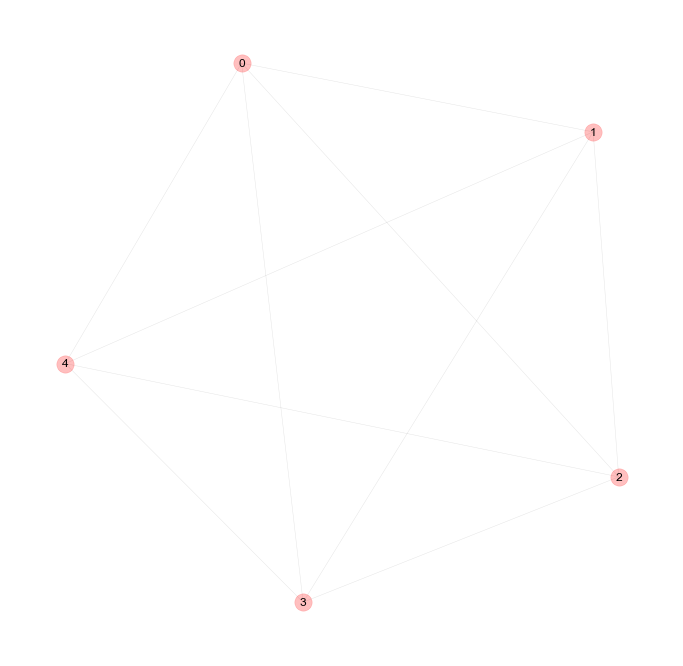

In [56]:
textacy.viz.network.draw_semantic_network(textacy.network.sents_to_semantic_network(list(my_doc.sents)), draw_nodes=True, spread=20)

In [57]:
textacy.similarity.hamming('great', 'graett')

0.5

In [58]:
textacy.similarity.jaccard('great', 'ggraett')

1.0

In [59]:
textacy.similarity.jaccard('great', 'hraetttr')

0.6666666666666666

In [60]:
textacy.similarity.levenshtein('great', 'graett')

0.6666666666666667